<a href="https://colab.research.google.com/github/kpe/notebooks/blob/master/atis_resplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import itertools

from collections import defaultdict, Counter
from random import Random
from functools import partial

from urllib import request, parse

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# The ATIS Dataset

The ATIS DataSet is widely used [TODO add the references] benchmark dataset for intent classification and slot filling models used in dialog systems.

This notebook will:
  
  1. fetch the ATIS DataSet from https://github.com/yvchen/JointSLU 
  2. Explore the the slot and intent label distribution accross the the train/dev/test dataset split
  3. Provide an alternative (balanced) datasplit
  







## Fetching the dataset
The ATIS dataset from [yvchen/JointSLU](https://github.com/yvchen/JointSLU) is provided as train, dev and test split in text format, one sample per line with whitespace separated tokens and IOB tags, followeb by the intent label, i.e.:

    BOS from denver to baltimore EOS O O B-fromloc.city_name O B-toloc.city_name atis_flight
    BOS ground transportation in denver EOS  O O O O B-city_name atis_ground_service

In [12]:
ATIS_BASE_URL="https://raw.githubusercontent.com/yvchen/JointSLU/master/data/"

def load_atis_ds(fname, base_url=ATIS_BASE_URL):
    res = []
    with request.urlopen(parse.urljoin(base_url,fname)) as req:
        for line in req.readlines():
            line = line.decode(req.info().get_content_charset())
            toks,si      = map(str.split, line.split("\t"))
            slots,intent = si[:-1]+['O'], si[-1]
            assert len(toks) == len(slots)
            res.append((toks, slots, intent))
    ds_name = '.'.join(fname.split('.')[:2])
    print('{:>20s}: {:4d}'.format(ds_name, len(res)))
    return res, ds_name

atis = {name: ds for ds, name in 
        map(load_atis_ds, map(lambda name: name+'.w-intent.iob',
                              ['atis.test', 'atis-2.dev','atis-2.train']))}


           atis.test:  893
          atis-2.dev:  500
        atis-2.train: 4478


## Exploring the data splits

In [17]:
# a single entry looks like this
toks,slots,intent = atis['atis.test'][0]
print(' input:', ' '.join(toks))
print(' slots:', ' '.join(slots))
print('intent:',          intent)

 input: BOS i would like to find a flight from charlotte to las vegas that makes a stop in st. louis EOS
 slots: O O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name O
intent: atis_flight


Lets check if all labels are present in both the train and test (or dev) data splits.

In [42]:
test,dev,train = map(atis.get, ['atis.test','atis-2.dev','atis-2.train'])

def subdict(d, keys):
  return {key: d[key] for key in set(keys)}

def atis_label_counts(ds):
  tokens, slots, intents = zip(*ds)
  token_labs  = Counter(list(itertools.chain.from_iterable(tokens)))
  slot_labs   = Counter(list(itertools.chain.from_iterable(slots)))
  intent_labs = Counter(intents)
  return token_labs, slot_labs, intent_labs

def check_atis_split(train, dev, test):
  (_,ts,ti), (_,ds,di), (_,es,ei) = map(atis_label_counts,
                                        [train, dev, test])

  lens = np.array(list(map(len, [train,dev,test])))
  print("sample count: {:5d} splitted into:".format(lens.sum()))
  for dslen, dsname in zip(lens, ['train', 'dev', 'test']):
    print("       {:>5s}: {:5d} ({:.3f})".format(dsname, dslen, dslen/lens.sum()))
  

  
  # map slot/intent labels to usage frequency
  token_labs,slot_labs,intent_labs = atis_label_counts(train+dev+test)
  sfreqs, ifreqs = map(partial(partial,subdict), [slot_labs, intent_labs])

  print("intent count:", len(intent_labs))
  print("  slot count:", len(slot_labs))
  print(" token count:", len(token_labs))
  
  print("missing data for slot/intent labels:")
  ts,ti,ds,di,es,ei = map(lambda s: set(s.keys()), [ts,ti,ds,di,es,ei])
  for dsname, mints, mslots in [("train", 
                                 ifreqs(di.union(ei).difference(ti)),
                                 sfreqs(ds.union(es).difference(ts))),
                                ("dev", 
                                 ifreqs(ti.difference(di)),
                                 sfreqs(ts.difference(ds))),
                                ("test", 
                                 ifreqs(ti.difference(ei)),
                                 sfreqs(ts.difference(es)))]:
    print("  no {:>5s} data for {:2d} intents: {}".format(dsname, 
                                                       len(mints), mints))
    print("  no {:>5s} data for {:2d}   slots: {}".format(dsname, 
                                                       len(mslots), mslots))


check_atis_split(train, dev, test)

sample count:  5871 splitted into:
       train:  4478 (0.763)
         dev:   500 (0.085)
        test:   893 (0.152)
intent count: 26
  slot count: 127
 token count: 952
missing data for slot/intent labels:
  no train data for  5 intents: {'atis_airfare#atis_flight_time': 1, 'atis_day_name': 2, 'atis_airfare#atis_flight': 1, 'atis_flight_no#atis_airline': 1, 'atis_flight#atis_airline': 1}
  no train data for  7   slots: {'I-return_date.day_number': 1, 'B-compartment': 1, 'B-booking_class': 1, 'I-state_name': 1, 'B-flight': 1, 'I-flight_number': 1, 'B-stoploc.airport_code': 1}
  no   dev data for  6 intents: {'atis_flight_no': 20, 'atis_aircraft#atis_flight#atis_flight_no': 1, 'atis_cheapest': 1, 'atis_meal': 12, 'atis_ground_service#atis_ground_fare': 1, 'atis_airline#atis_flight_no': 2}
  no   dev data for 25   slots: {'B-time_relative': 1, 'B-today_relative': 2, 'I-arrive_time.time_relative': 6, 'I-meal_code': 4, 'I-arrive_date.day_number': 6, 'B-month_name': 2, 'B-time': 2, 'I-mea

So from above, we see, there are 5 intent and 7 slot labels not present at all in the train dataset. And quite simillary up to 20% of the labels are not present in the dev or test dataset.

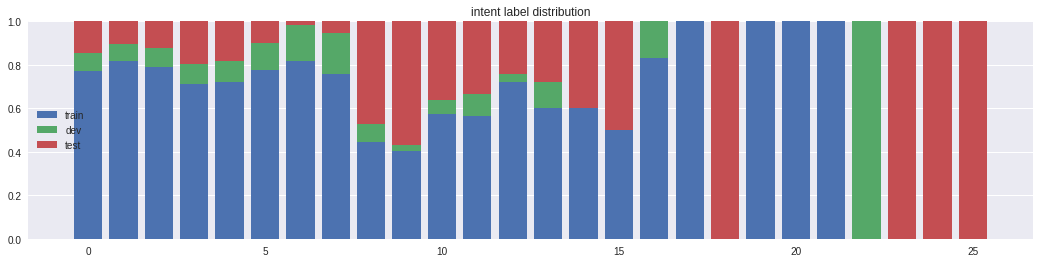

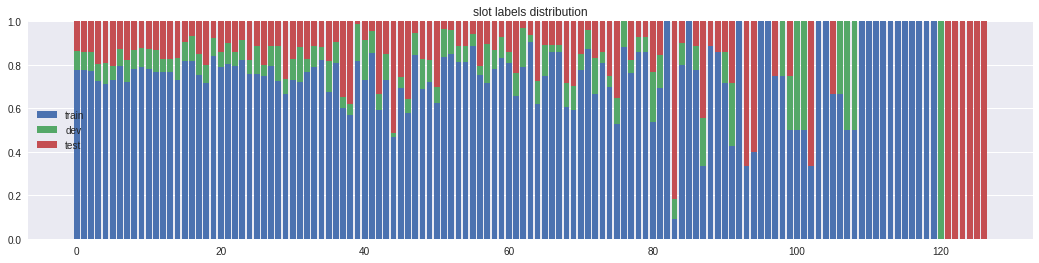

In [60]:
def visualize_atis_split(train,dev,test):
  (_,ts,ti), (_,ds,di), (_,es,ei) = map(atis_label_counts,
                                        [train, dev, test])
  _,alls, alli = atis_label_counts(train+dev+test)

  tsc,dsc,esc,asc = (np.array([d[slot]   for slot,_   in alls.most_common()]) 
                     for d in [ts,ds,es, alls])
  tic,dic,eic,aic = (np.array([d[intent] for intent,_ in alli.most_common()]) 
                     for d in [ti,di,ei, alli])

  plt.figure(figsize=(18,4))
  plt.title('intent label distribution')
  plt.bar(x=np.arange(len(tic)), height=tic/aic,                       label='train')
  plt.bar(x=np.arange(len(dic)), height=dic/aic, bottom=tic/aic,       label='dev')
  plt.bar(x=np.arange(len(eic)), height=eic/aic, bottom=(tic+dic)/aic, label='test')
  plt.legend(loc='center left', fancybox=True, framealpha=0.5)

  plt.figure(figsize=(18,4))
  plt.title('slot labels distribution')
  plt.bar(x=np.arange(len(tsc)), height=tsc/asc,                       label='train')
  plt.bar(x=np.arange(len(dsc)), height=dsc/asc, bottom=tsc/asc,       label='dev')
  plt.bar(x=np.arange(len(esc)), height=esc/asc, bottom=(tsc+dsc)/asc, label='test')
  plt.legend(loc='center left', fancybox=True, framealpha=0.5)

visualize_atis_split(train,dev,test)

## Splitting the ATIS dataset

Befere we split, we should better remove all samples containing labels occurnig less than 3 times (we actually remove samples with labels occurring less than 4 times, after expecting the output of `check_atis_split()` for a dataset cleaned with the "less than 3 times" label rule).

In [92]:
test,dev,train = map(atis.get, ['atis.test','atis-2.dev','atis-2.train'])
atis_all = train + dev + test

# count label frequencies
_, slot_labs, intent_labs = atis_label_counts(atis_all)

# filter labels occuring only once per split
clean_slots   = dict(filter(lambda t: t[1] > 3, slot_labs.most_common()))
clean_intents = dict(filter(lambda t: t[1] > 3, intent_labs.most_common()))

# remove the corresponding data samples
atis_clean = list(filter(lambda t: set(t[1]).issubset(clean_slots), 
                         atis_all))
atis_clean = list(filter(lambda t: t[2] in clean_intents,
                         atis_clean))

print("original ATIS data count:",len(atis_all))
print("cleaned  ATIS data count:",len(atis_clean))

original ATIS data count: 5871
cleaned  ATIS data count: 5831


In [0]:
def split_atis(ads, split=[0.8, 0.1, 0.1],random_state=None):
  """ Splits the ATIS dataset by starting with the least common labels."""
  split = np.array(split)
  assert split.sum() == 1
  
  random = None if random_state is None else Random(random_state)
    
  res=[[] for _ in split]
  used = set()             # used samples
  s2e = defaultdict(set)   # slot to sample
  i2e = defaultdict(set)   # intent to sample
  for ndx, (_,slots,intent) in enumerate(ads): # build label to sample maps
    i2e[intent].add(ndx)
    for slot in set(slots):
      s2e[slot].add(ndx)
    
  # sort according to usage
  s2f = Counter({slot:len(ndxs)   for slot,ndxs   in s2e.items()}).most_common()
  i2f = Counter({intent:len(ndxs) for intent,ndxs in i2e.items()}).most_common()
  
  while True:
    # select the least common intent or slot label
    if len(i2f)<1 and len(s2f)<1:            # both empty
      break
    elif len(i2f)>0 and len(s2f)>0:          # both non empty
      use_intent = i2f[-1][1] < s2f[-1][1]   #
    else:
      use_intent = len(i2f)>0
           
    # get the samples of least common label
    if use_intent:
      intent, _ = i2f.pop()
      ndxs = i2e.pop(intent)
    else:
      slot, _ = s2f.pop()
      ndxs = s2e.pop(slot)
        
    # shuffle the samples of the selected label
    ndxs = list(ndxs)
    if random is not None:
      random.shuffle(ndxs)
    
    splits = [[] for _ in split]
    # put each sample in a split maintaining the split ratios    
    for ndx in ndxs:
      lens = np.array([len(sp) for sp in splits])
      # fill the split with the highest frequency (reverse ratio) offset
      sndx = np.argmax(1/(lens/(lens.sum()+1e-12)+1e-12) - 1/split)
      if ndx not in used:
        used.add(ndx)
        splits[sndx].append(ndx)

    # add the splitted label samples to the result split
    for ndx, ndxs in enumerate(splits):
      res[ndx].extend(ndxs)
            
  return res

In [0]:
train,test,dev = split_atis(atis_clean,[0.8,0.1,0.1], random_state=7411)
train,test,dev = map(lambda ndxs: np.array(atis_clean)[ndxs].tolist(),
                     [train,test,dev])


In [95]:
check_atis_split(train,dev,test)

sample count:  5831 splitted into:
       train:  4588 (0.787)
         dev:   618 (0.106)
        test:   625 (0.107)
intent count: 17
  slot count: 102
 token count: 946
missing data for slot/intent labels:
  no train data for  0 intents: {}
  no train data for  0   slots: {}
  no   dev data for  0 intents: {}
  no   dev data for  0   slots: {}
  no  test data for  0 intents: {}
  no  test data for  0   slots: {}


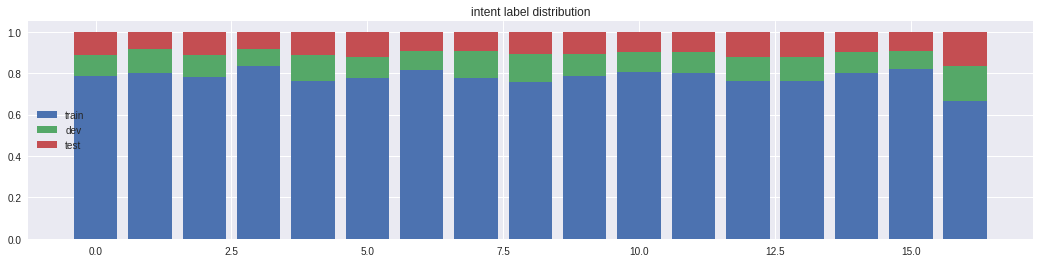

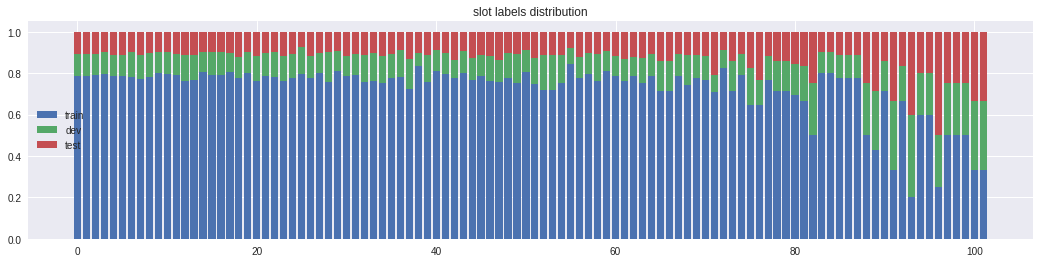

In [96]:
visualize_atis_split(train,dev,test)

## Dump the ATIS data split

We dump the ATIS datasets using the same format as in [link it].

In [97]:
# ok, lest store the split
import gzip, pickle

DATA_DIR="./"

def store_ds(ds,dicts, fname='atis-clean.train.pkl.gz'):
    with gzip.open(os.path.join(DATA_DIR, fname), 'wb') as stream:
        pickle.dump((ds,dicts),stream, protocol=pickle.HIGHEST_PROTOCOL)
    print('Done  dumping: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))    

def load_ds(fname='atis-clean.train.pkl.gz'):
    with gzip.open(os.path.join(DATA_DIR, fname), 'rb') as stream:
        ds,dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts

def to_ds_with_dicts(train,dev,test):
    toks, slots, intents = atis_label_counts(train+dev+test)
    dicts = {}
    dicts['token_ids']  = {tok:ndx    for ndx, (tok, _) in enumerate(toks.most_common(),1)}
    dicts['slot_ids']   = {slot:ndx   for ndx, (slot, _) in enumerate(slots.most_common(),1)}
    dicts['intent_ids'] = {intent:ndx for ndx, (intent, _) in enumerate(intents.most_common(),1)}
    
    def to_ds(ds):
        res = {}
        res['query']         = [[dicts['token_ids'][tok] for tok in toks]   for toks, _, _ in ds]
        res['slot_labels']   = [[dicts['slot_ids'][slot] for slot in slots] for _, slots, _ in ds]
        res['intent_labels'] = [[dicts['intent_ids'][intent]]               for _, _, intent in ds]
        return res
    
    return dicts, to_ds(train), to_ds(dev), to_ds(test)

ndicts, ntrain_ds, ndev_ds, ntest_ds = to_ds_with_dicts(train,dev,test)

store_ds(ntrain_ds, ndicts, 'atis-clean.train.pkl.gz')
store_ds(ntest_ds,  ndicts, 'atis-clean.test.pkl.gz')
store_ds(ndev_ds,   ndicts, 'atis-clean.dev.pkl.gz')

Done  dumping:  atis-clean.train.pkl.gz
      samples: 4588
   vocab_size:  946
   slot count:  102
 intent count:   17
Done  dumping:  atis-clean.test.pkl.gz
      samples:  625
   vocab_size:  946
   slot count:  102
 intent count:   17
Done  dumping:  atis-clean.dev.pkl.gz
      samples:  618
   vocab_size:  946
   slot count:  102
 intent count:   17
